In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  # pip install scikit-learn

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("/content/01_data_processed.pkl")

In [13]:
display(df.head())

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,excercise,intensity,ind
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy1,28
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy1,28
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy1,28
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy1,28
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy1,28


acc_y    Axes(0.08,0.07;0.87x0.81)
dtype: object

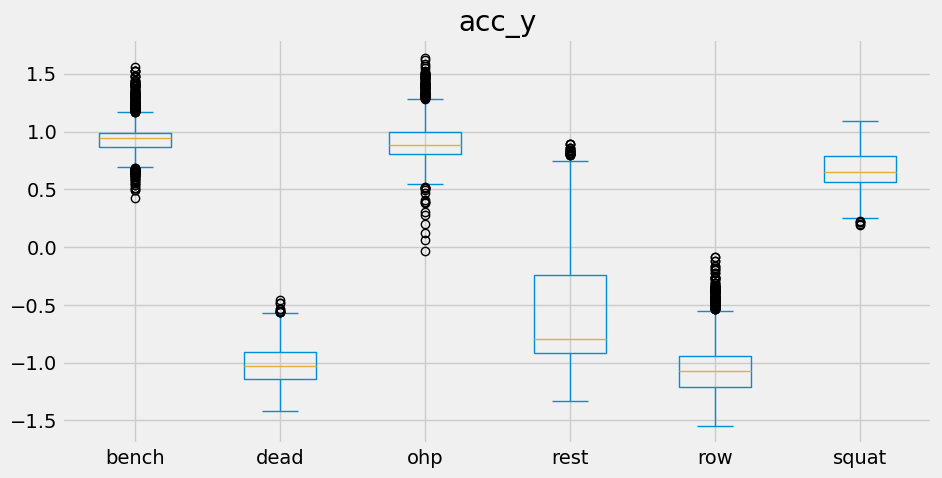

In [20]:
# --------------------------------------------------------------
# Plotting outliers
# --------------------------------------------------------------
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

df[["acc_y", "excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (10, 5),
                                label = "excercise", )

gyro_y    Axes(0.08,0.07;0.87x0.81)
dtype: object

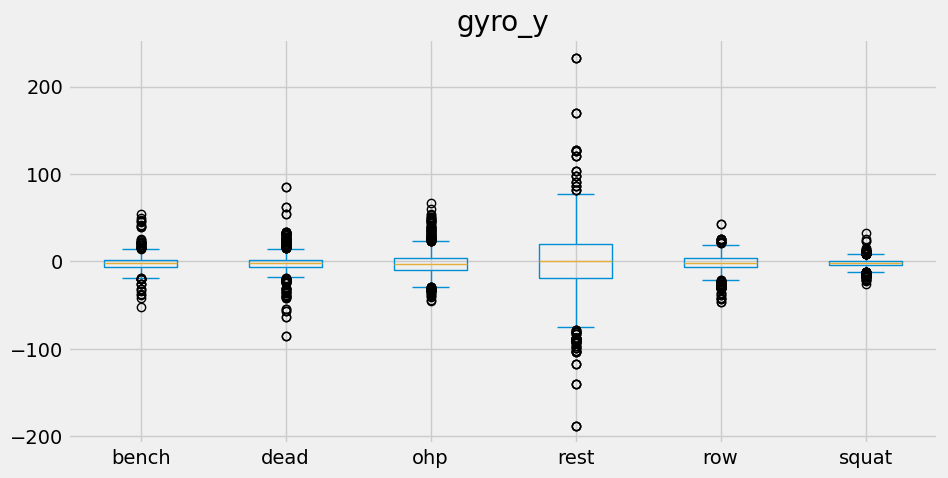

In [21]:
df[["gyro_y", "excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (10, 5),
                                label = "excercise", )

acc_x        Axes(0.08,0.07;0.255882x0.81)
acc_y    Axes(0.387059,0.07;0.255882x0.81)
acc_z    Axes(0.694118,0.07;0.255882x0.81)
dtype: object

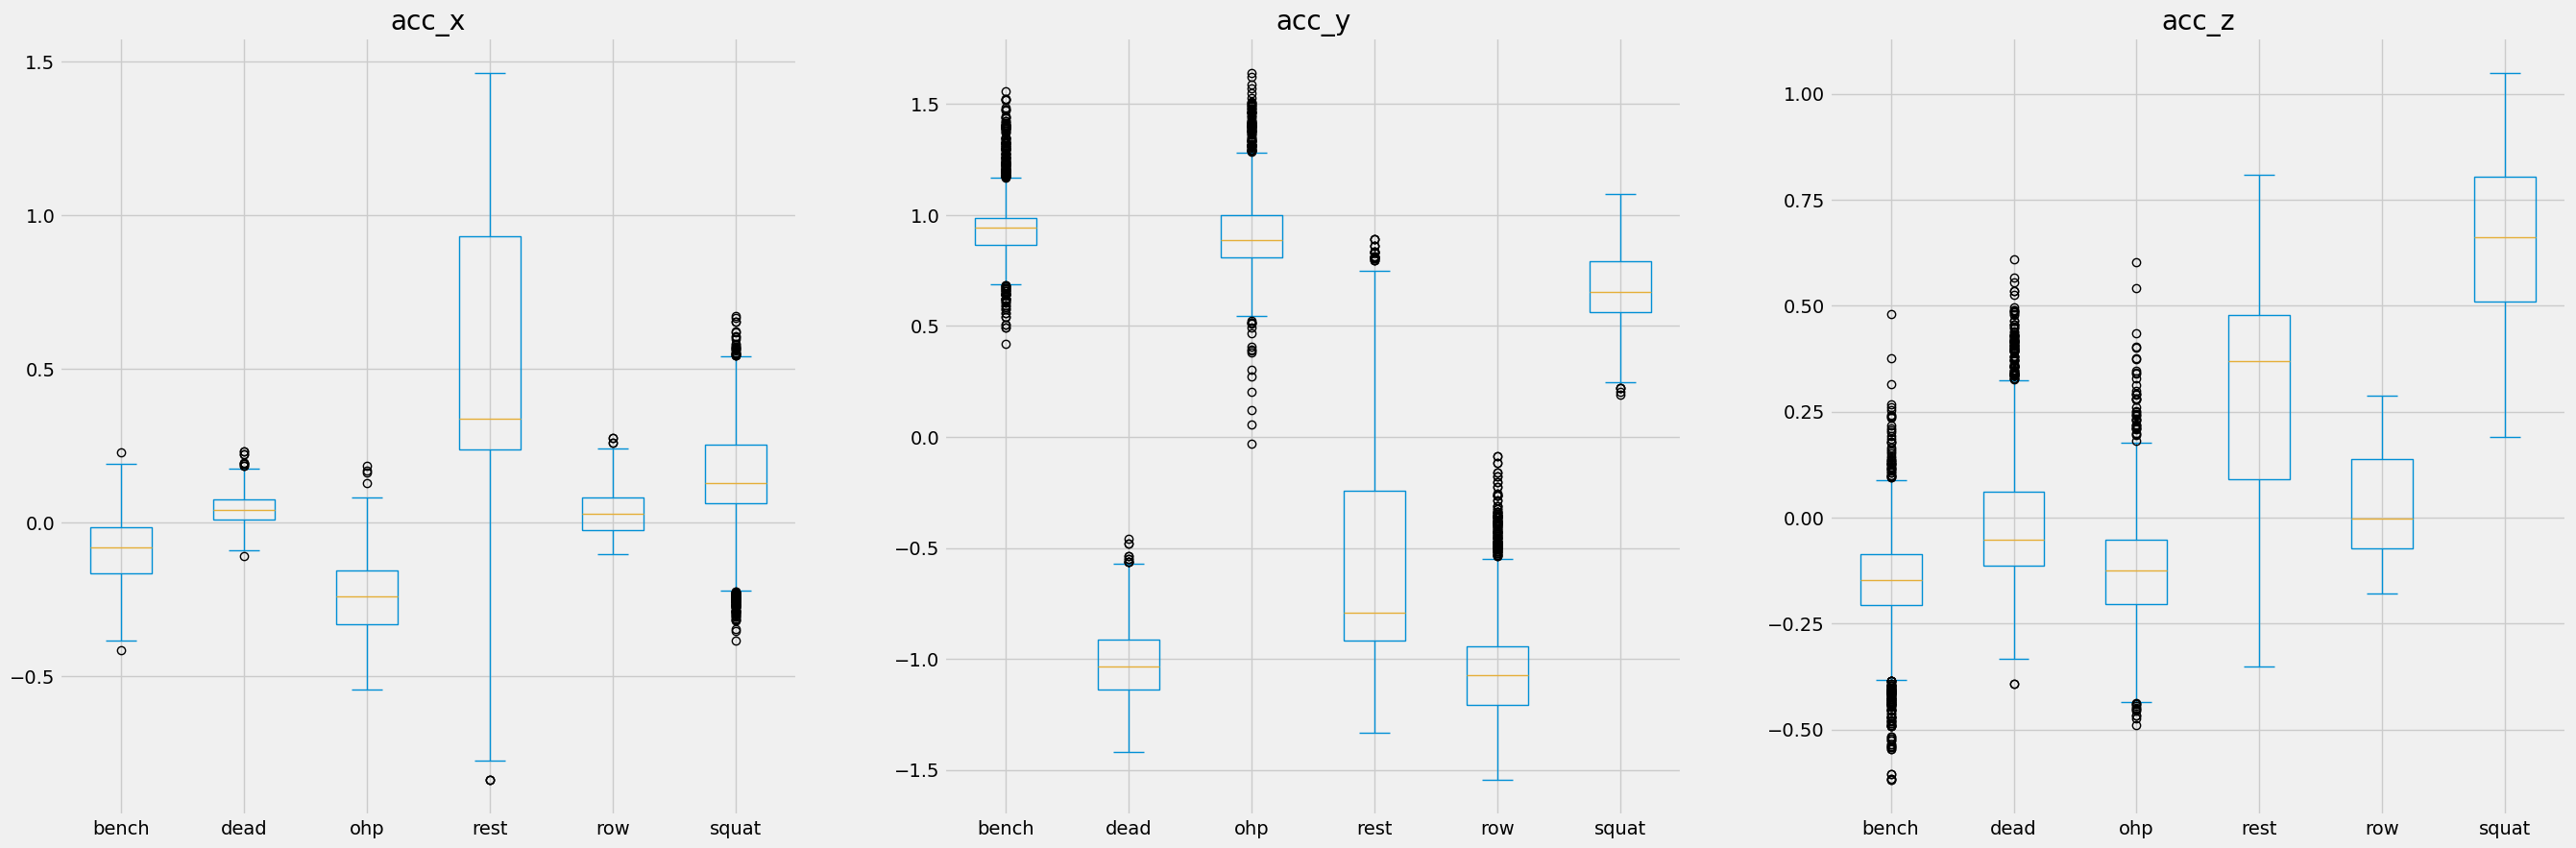

In [71]:
col_num = list(df.select_dtypes([np.number]).columns)
col_num.remove("ind")
# Plotting accelerometer data
df[col_num[:3] + ["excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (30, 10),
                                label = "excercise",
                                     layout = (1, 3))


gyro_x        Axes(0.08,0.07;0.255882x0.81)
gyro_y    Axes(0.387059,0.07;0.255882x0.81)
gyro_z    Axes(0.694118,0.07;0.255882x0.81)
dtype: object

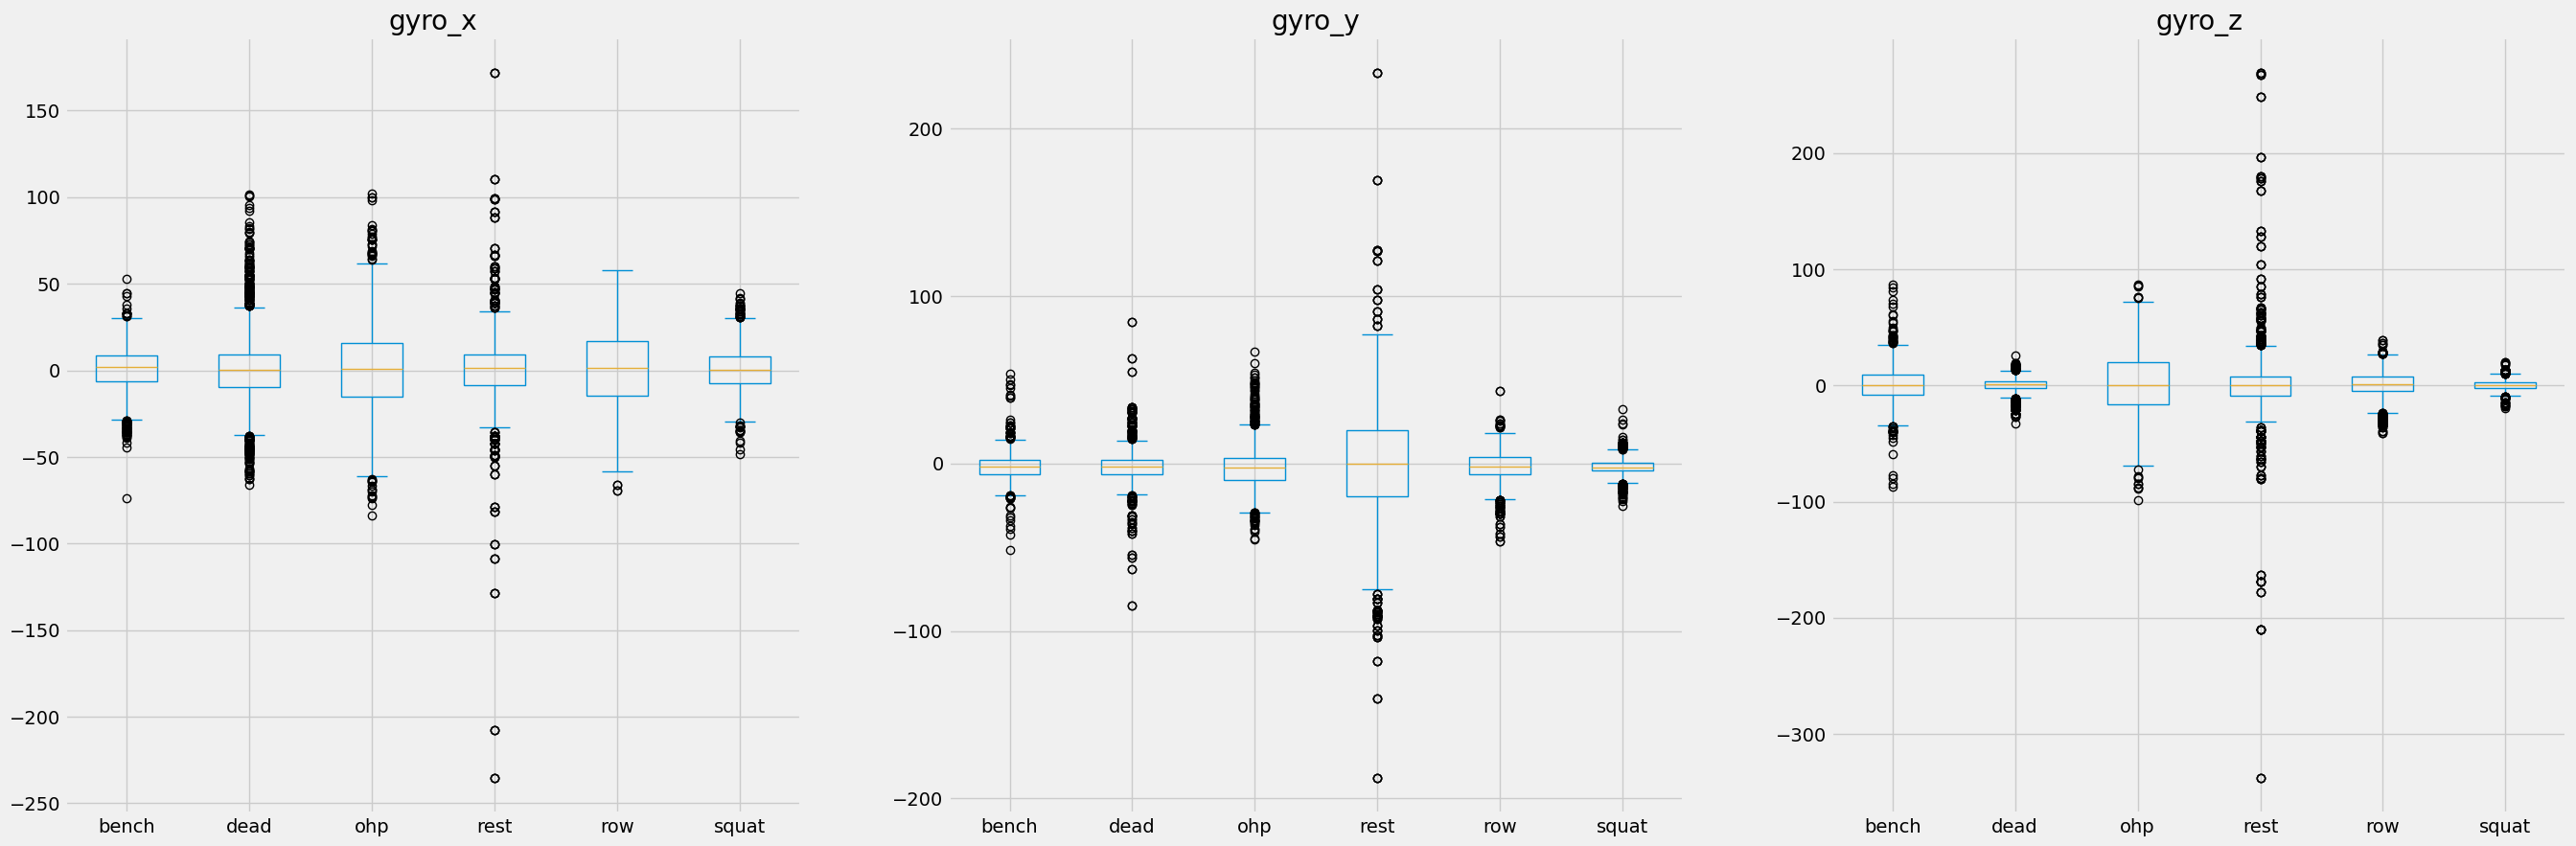

In [45]:
# Plotting gyroscope data
df[col_num[3:6] + ["excercise"]].plot(by = "excercise",
                                kind = "box",
                                figsize = (30, 10),
                                label = "excercise",
                                      layout = (1, 3))

In [46]:
# Plotting outliers in time
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

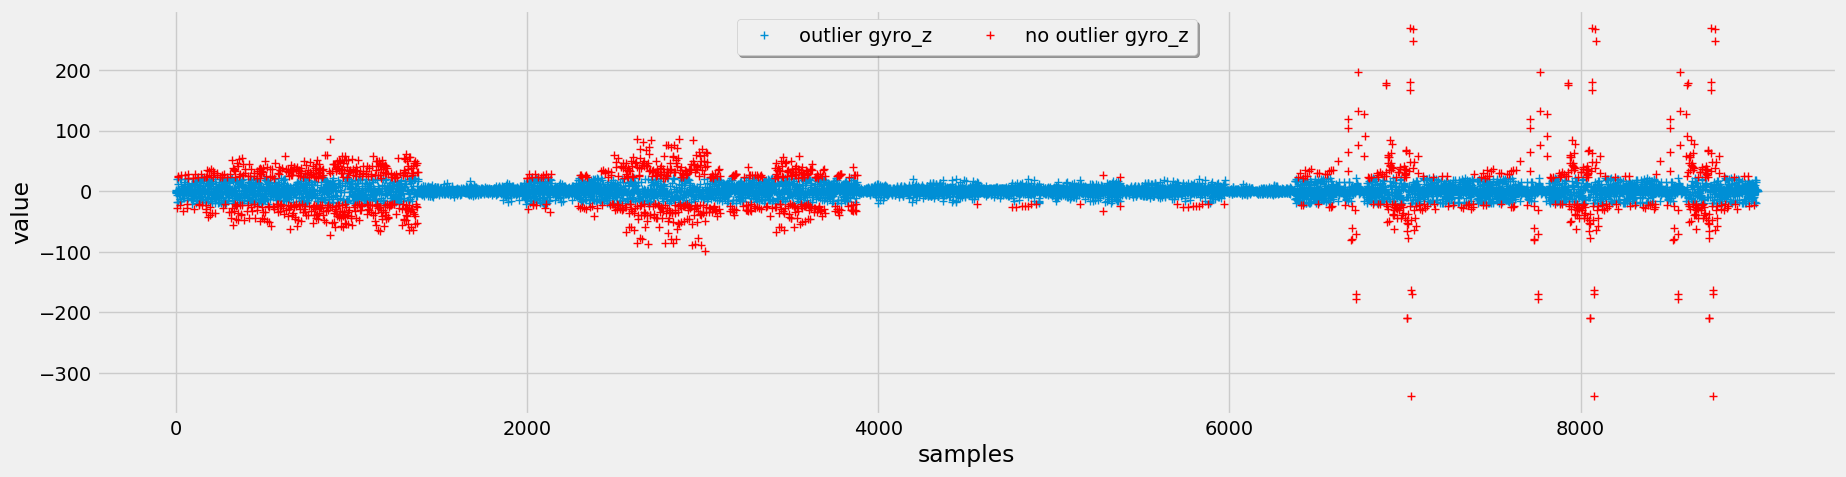

In [72]:
# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function
def outliers(df, col):
  Q1 = np.percentile(df[col], 25, method='midpoint')
  Q3 = np.percentile(df[col], 75, method='midpoint')
  IQR = Q3 - Q1
  return np.array((df[col] > Q3 + IQR * 1.5) | (df[col] < Q1 - IQR * 1.5))

# Plot a single column
col = "gyro_z"
df["outlier"] = outliers(df, col)
plot_binary_outliers(df, col, "outlier", True)



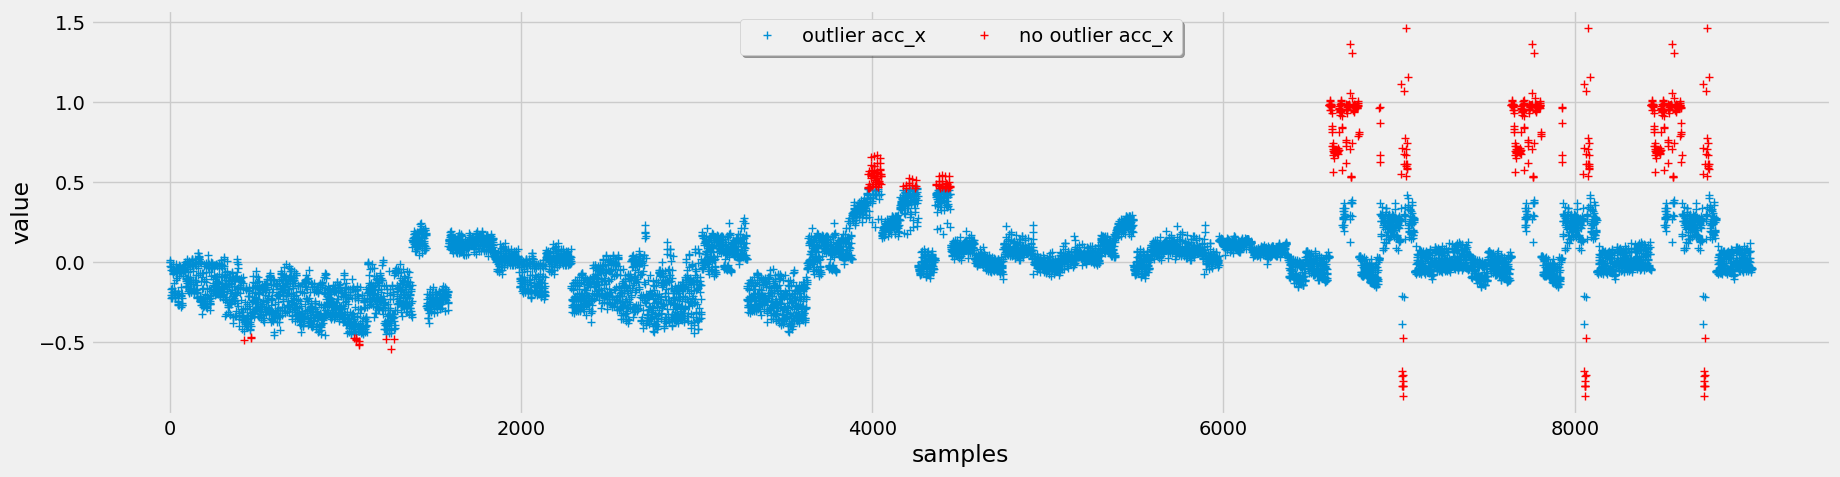

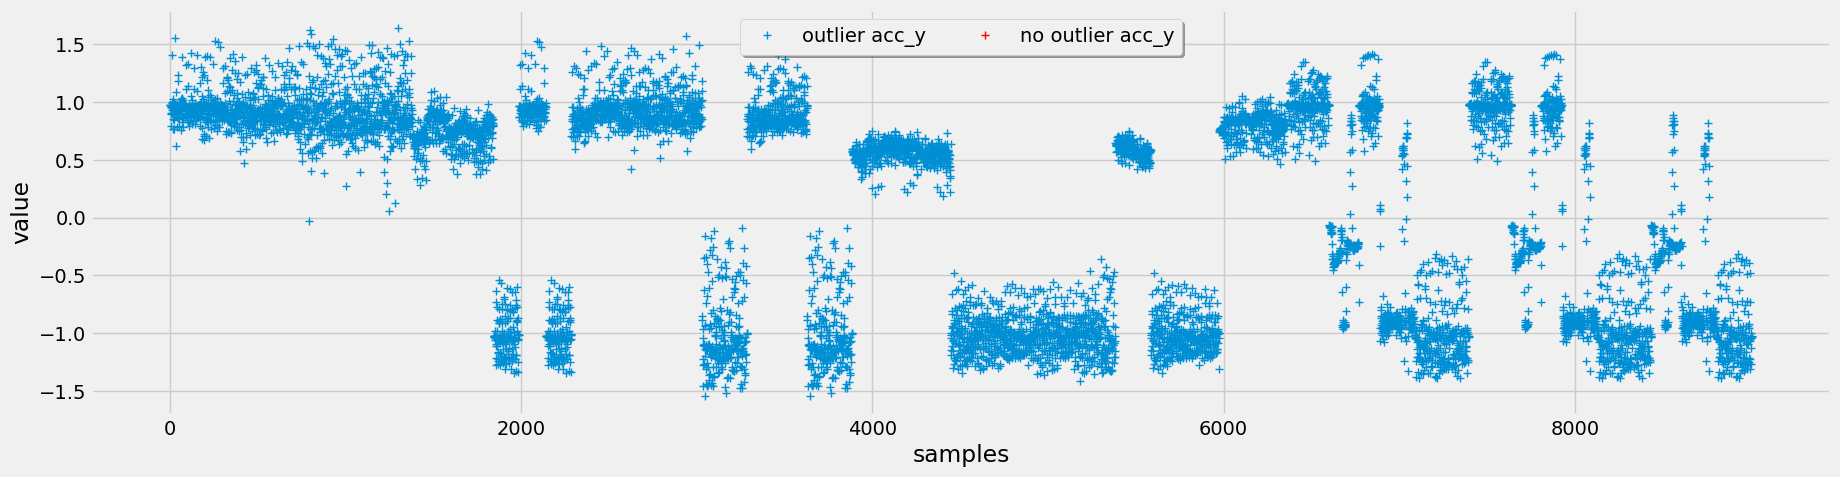

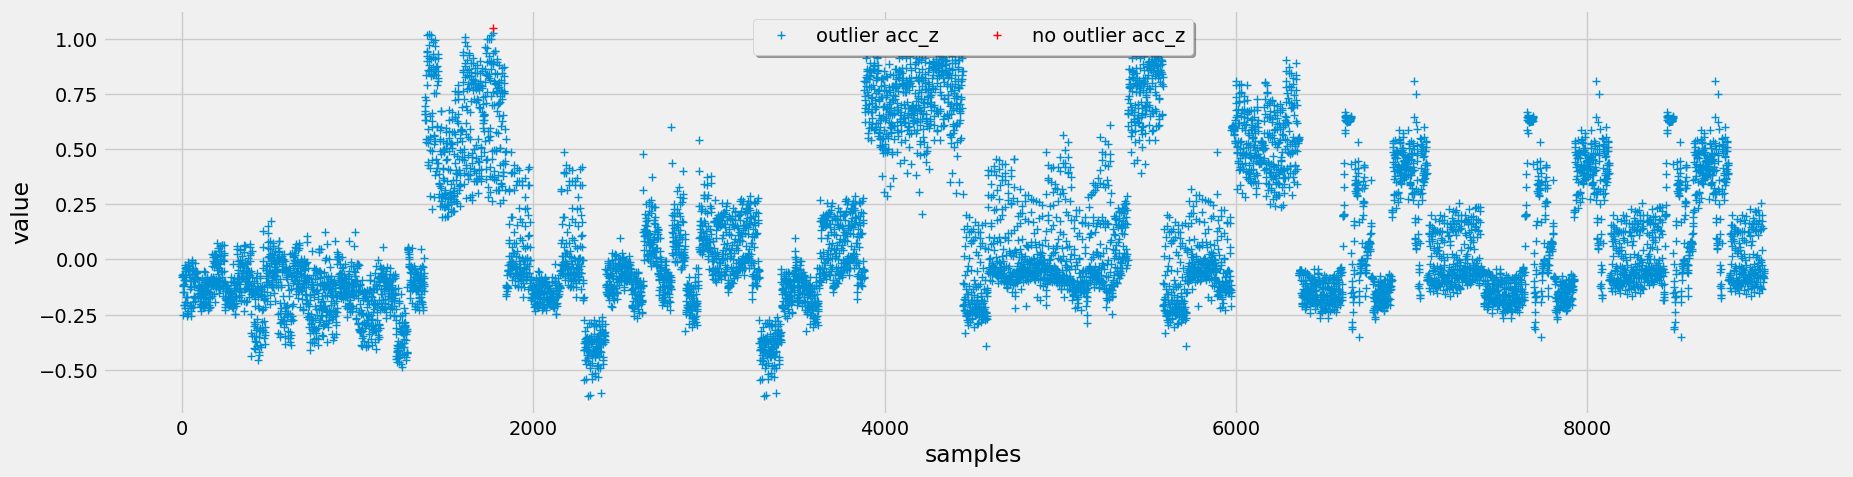

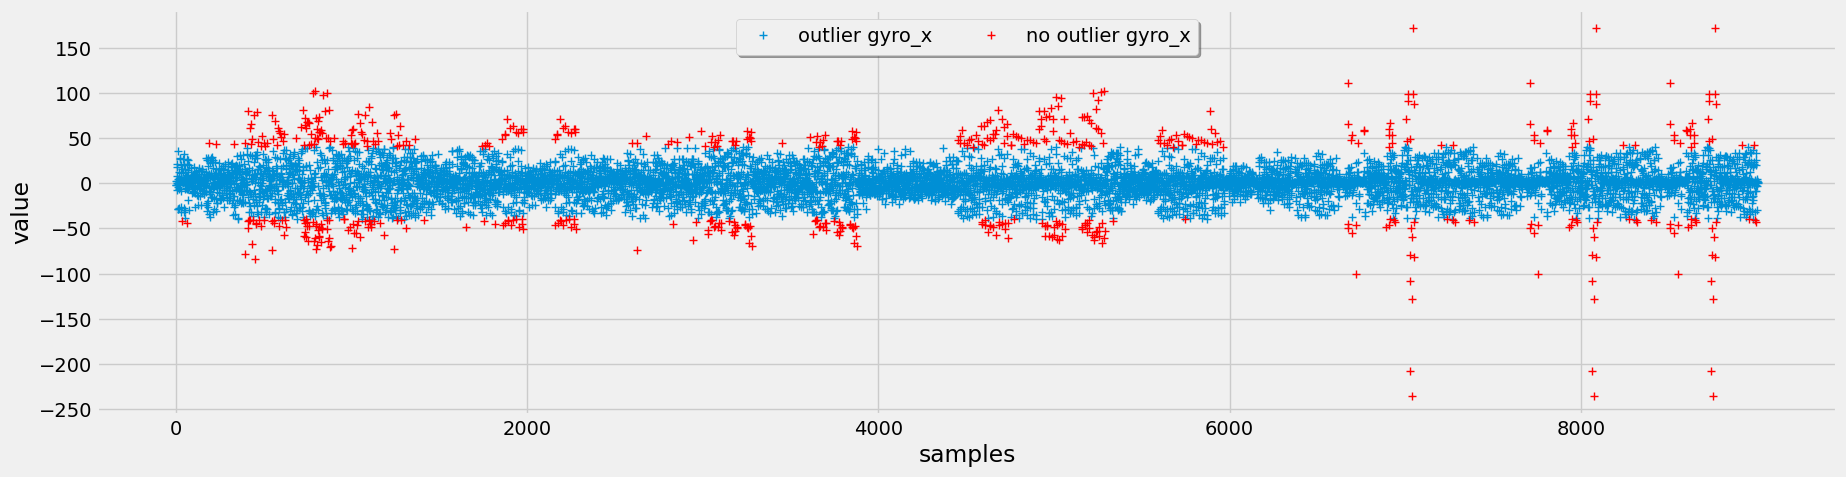

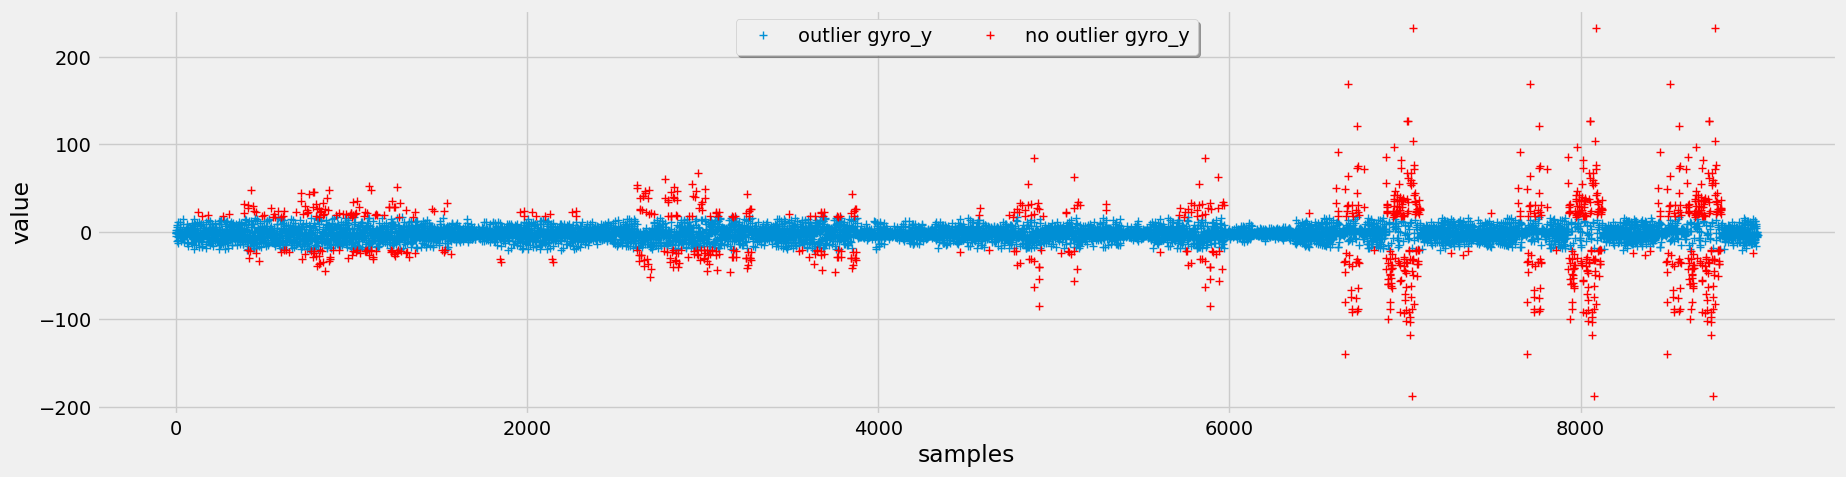

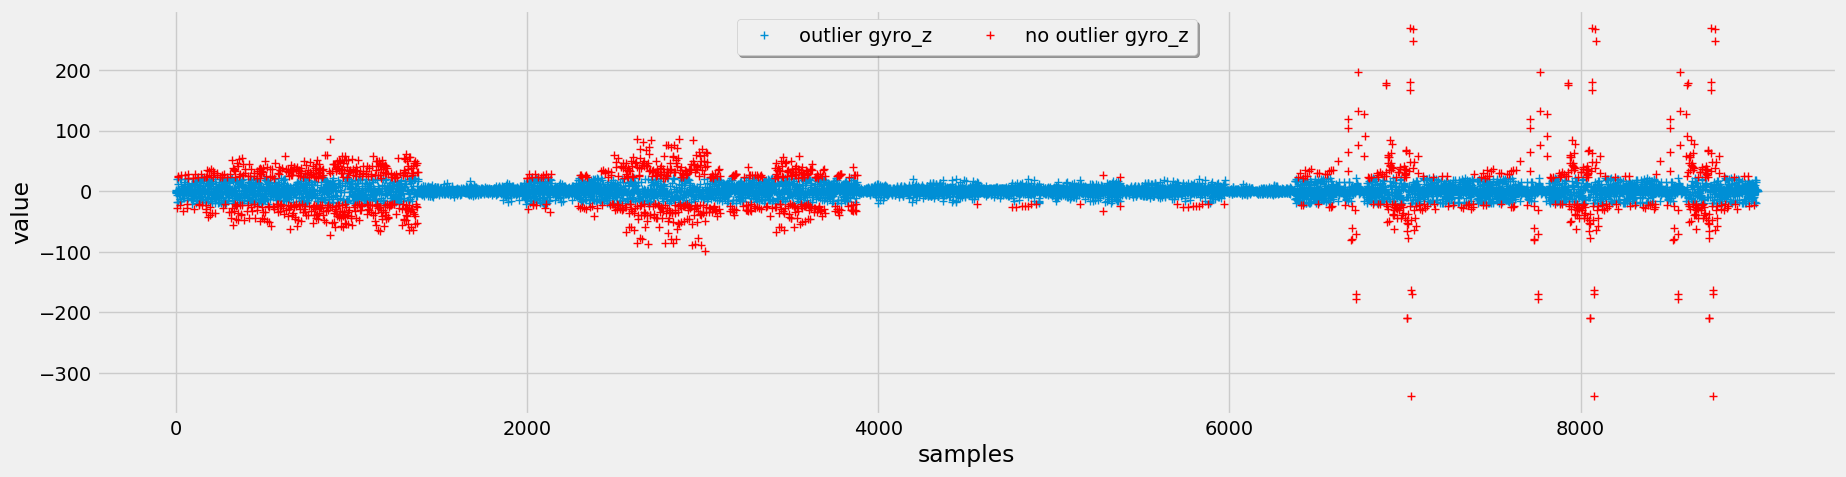

In [73]:
# Loop over all columns
for col in col_num:
  df[f"{col}_outlier"] = outliers(df, col)
  # Plot a single column
  plot_binary_outliers(df, col, f"{col}_outlier", True)

In [ ]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    """
    Function to identify outliers based on Chauvenet's criteria:

    A point is an outlier if in a dataset of len == N the probability of the
    point being present is < 1/(2*N)

    Works under the assumption that the dataset is normally distributed

    Inputs:
    df = Dataset
    col = Column for uotlier calculation
    C = the constant in Chauvenets criteria (default = 2)

    OUtput:
    df = modified dataset with outlier column
    """
    df = df.copy()
    m = df.col.mean()
    sd = df.col.std()
    p = 1 / (2 * len(df))




    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

In [4]:
# --------------------------------------------------------------
# Chauvenets criteron (distribution based)
# --------------------------------------------------------------

# Check for normal distribution


# Insert Chauvenet's function


# Loop over all columns




In [5]:
# --------------------------------------------------------------
# Local outlier factor (distance based)
# --------------------------------------------------------------

# Insert LOF function


# Loop over all columns




In [6]:
# --------------------------------------------------------------
# Check outliers grouped by label
# --------------------------------------------------------------




In [7]:
# --------------------------------------------------------------
# Choose method and deal with outliers
# --------------------------------------------------------------

# Test on single column


# Create a loop



In [ ]:
# --------------------------------------------------------------
# Export new dataframe
# --------------------------------------------------------------